# Introduction

Metadata adata with cell type labels : /home/tchari/metadata/bus_stim.h5ad

Loom file with all cell types (in seawater control only): /home/tchari/counts/clytia_stim/loom/clytia_SWall_allGenes.loom

Script where I made loom files: https://github.com/tarachari3/perturbCME/blob/main/scripts/concatLoomsClytia.py

Notebook where I plot genes that change over development for nematocytes (also called cnidocytes in notebook): https://github.com/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/CellAtlasAnalysis/fullTrajAnalysis.ipynb
concatLoomsClytia.py
<https://github.com/tarachari3/perturbCME|tarachari3/perturbCME>tarachari3/perturbCME | Added by GitHub
fullTrajAnalysis.ipynb

# Preparation

In [1]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 


from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import scanpy as sc
import scvelo as scv

## Load data

In [4]:
metafile = "/home/tchari/metadata/bus_stim.h5ad"
loomfile = "/home/tchari/counts/clytia_stim/loom/clytia_SWall_allGenes.loom"
metadata = sc.read(metafile)
adata = sc.read(loomfile)

In [5]:
meta_mask = metadata.obs["condition"] == "SW"
adata.obs["annos"] = metadata.obs["annos"][meta_mask]
adata.obs["annosSub"] = metadata.obs["annosSub"][meta_mask]
adata.obs["louvain"] = metadata.obs["louvain"][meta_mask]
adata.obsm["X_pca"] = metadata.obsm["X_pca"][meta_mask]
adata.obsm["X_tsne"] = metadata.obsm["X_tsne"][meta_mask]
adata.obsm["X_umap"] = metadata.obsm["X_umap"][meta_mask]
adata

AnnData object with n_obs × n_vars = 5251 × 45872
    obs: 'Barcode', 'annos', 'annosSub', 'louvain'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

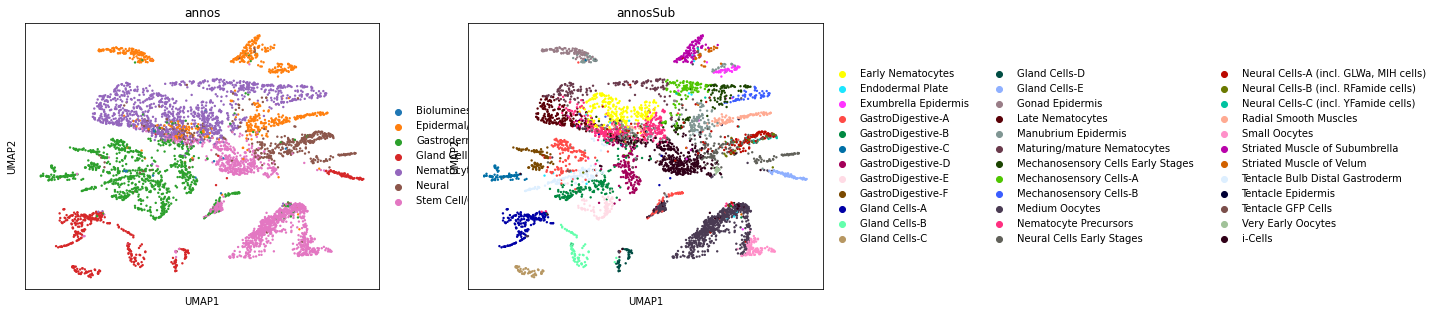

In [6]:
sc.pl.umap(adata,color=["annos","annosSub"])

## Select cells

In [7]:
celltypes = ['i-Cells','Nematocyte Precursors','Early Nematocytes','Late Nematocytes','Maturing/mature Nematocytes']
cell_mask = adata.obs["annosSub"].isin(celltypes)
data = adata[cell_mask]
data

View of AnnData object with n_obs × n_vars = 1424 × 45872
    obs: 'Barcode', 'annos', 'annosSub', 'louvain'
    uns: 'annos_colors', 'annosSub_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

Trying to set attribute `.uns` of view, copying.


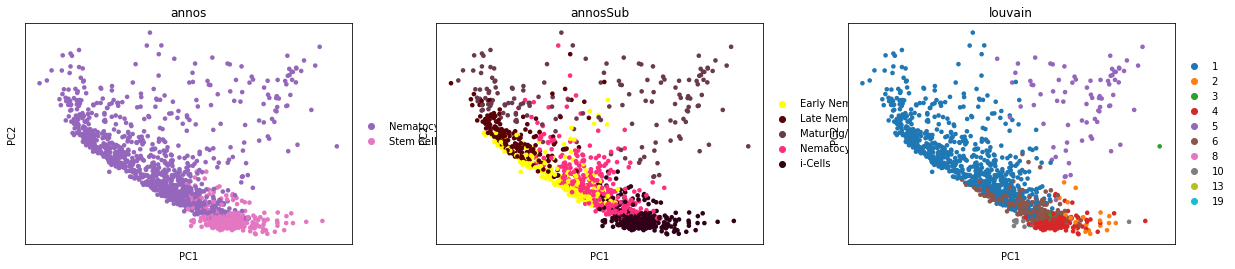

In [8]:
sc.pl.pca(data,color=["annos","annosSub","louvain"])

# Warm start

## Select genes

In [10]:
gene_mask = data.var_names.isin(metadata.var_names)
data = data[:,gene_mask]

In [26]:
sc.pp.highly_variable_genes(data,n_top_genes=10000,flavor="seurat_v3")
fitted_genes_mask = data.var['highly_variable'] & (data.layers['unspliced'].toarray().mean(axis=0)>0.1) & (data.layers['spliced'].toarray().mean(axis=0)>0.1)

X=np.zeros((data.shape[0],np.sum(fitted_genes_mask),2))
X[:,:,0]=data.layers['unspliced'].toarray()[:,fitted_genes_mask]
X[:,:,1]=data.layers['spliced'].toarray()[:,fitted_genes_mask]
X.shape

(1424, 87, 2)

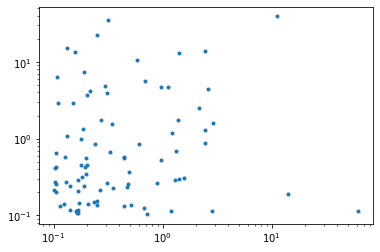

In [27]:
plt.loglog(np.mean(X[:,:,0],axis=0),np.mean(X[:,:,1],axis=0),'.');

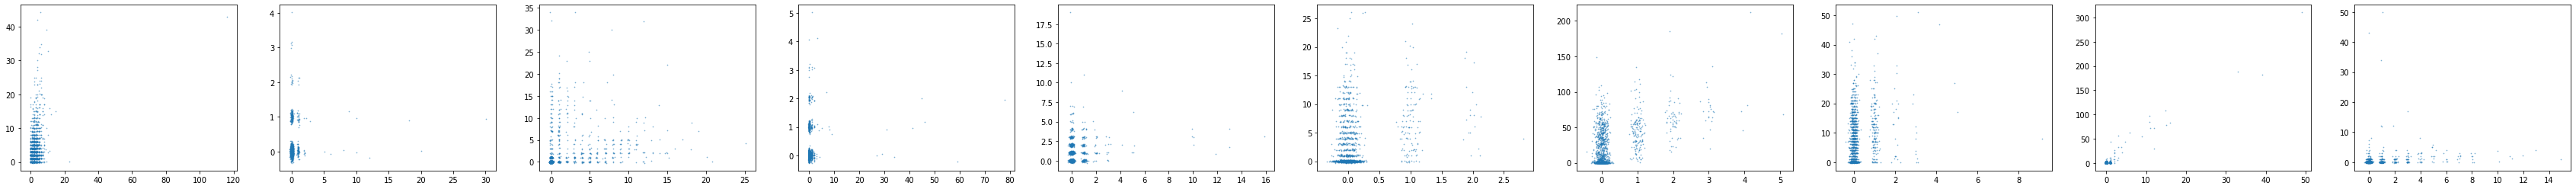

In [29]:
fix, ax = plt.subplots(1,10,figsize=(60,4))
for i in range(10):
    j = i
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,1424),X[:,j,1]+np.random.normal(0,0.1,1424),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [43]:
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
C =len(celltypes)
for i,celltype in enumerate(celltypes):
    idx = data.obs["annosSub"].isin([celltype])
    weight0[idx,int(i*m/C):int((i+1)*m/C)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

In [44]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj = Trajectory(topo, tau, verbose=1)
res = traj.fit(X,Q=Q0,epoch=20,parallel=True,n_threads=2)

run method fit_warm_start


100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


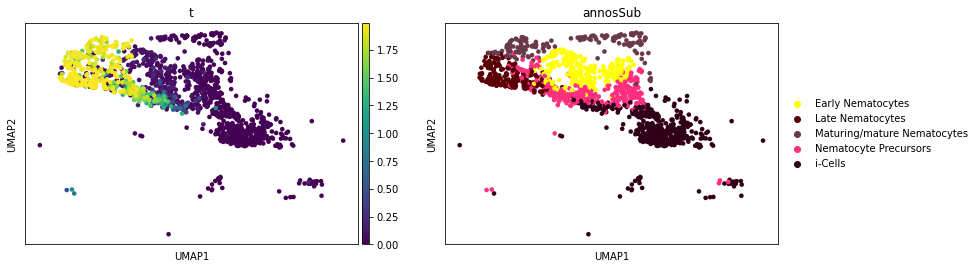

In [45]:
Q,elbos=res
data.obs["t"]=Q[:,0]@traj.t
sc.pl.umap(data,color=["t","annosSub"])

# Fitting

In [30]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj = Trajectory(topo, tau, verbose=1)
res = traj.fit_multi_init(X,100,n_init=3,epoch=20,parallel=True,n_threads=10)

trial 1


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

trial 2



100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

trial 3



100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


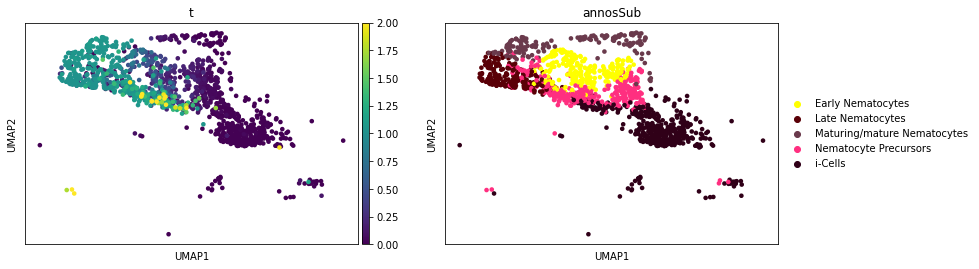

In [31]:
Q,elbos=res
data.obs["t"]=Q[:,0]@traj.t
sc.pl.umap(data,color=["t","annosSub"])

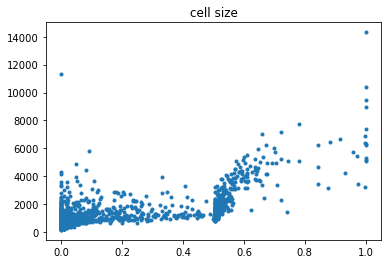

In [35]:
weight=Q[:,0]
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(data.layers["spliced"],axis=1),'.')#,c=colors20[np.mod(clusters, 20)])
plt.title("cell size");

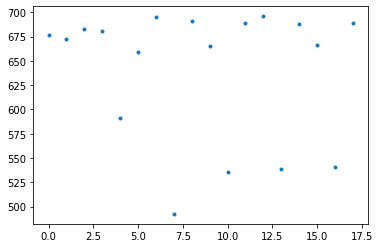

In [32]:
plt.plot(elbos,'.');

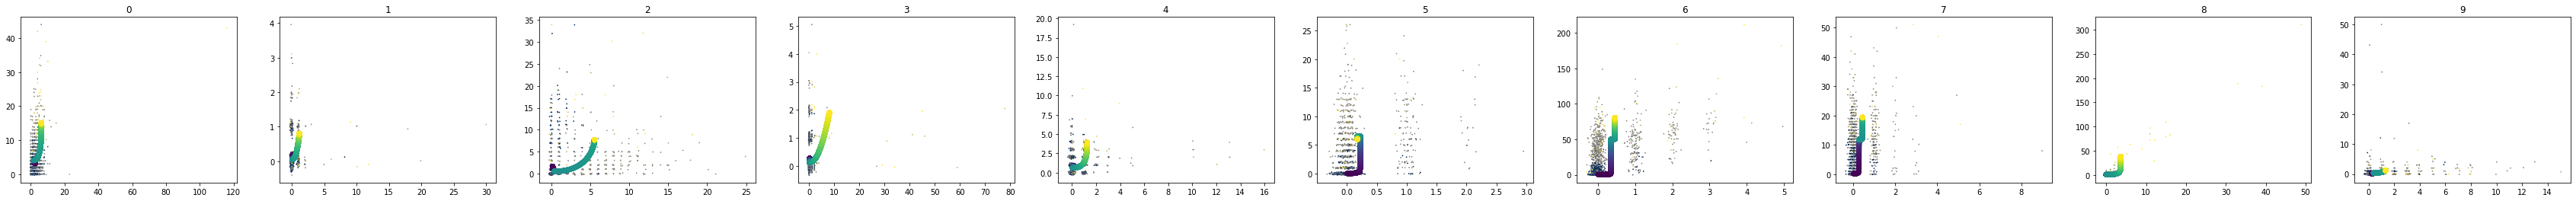

In [33]:
plot_phase(traj)

In [22]:
topo = np.array([[0]])
tau=(0,1)
traj = Trajectory(topo, tau, verbose=1)
res = traj.fit_multi_init(X,100,n_init=3,epoch=20,parallel=True,n_threads=2)

trial 1


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]

trial 2



100%|██████████| 20/20 [00:07<00:00,  2.73it/s]

trial 3



100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


In [23]:
Q,elbos=res
data.obs["t"]=Q[:,0]@traj.t

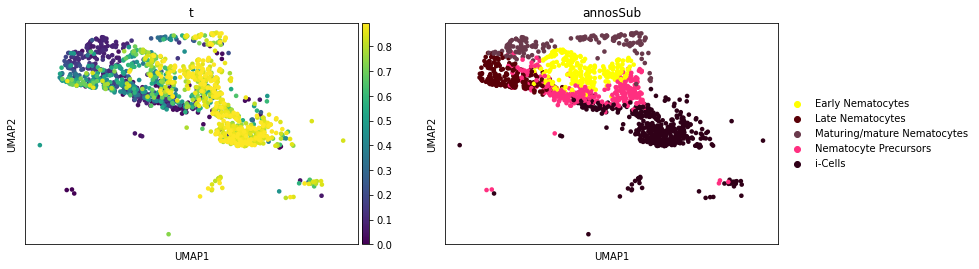

In [24]:
sc.pl.umap(data,color=["t","annosSub"])

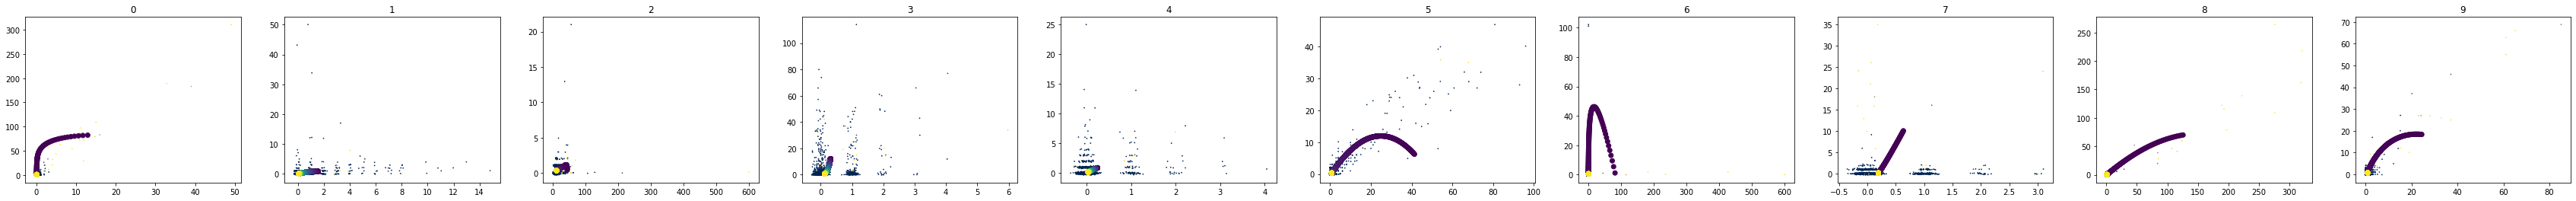

In [25]:
plot_phase(traj)